In [1]:
#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
#import scipy as sp
from scipy.signal import find_peaks
import peakutils

In [2]:
#assign filename variable
#example input: 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv


In [17]:
#import data from excel reference file
#import muscle bath tsv file (as pandas dataframe?)
#import corresponding comments file
df_file = pd.read_csv(filename, sep='\t')
df_ref = pd.read_csv(ref_filename, sep='\t')
comments_file = open(comments_filename,'r')

In [18]:
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])

In [19]:
#drop unneccessary columns
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#view first 5 rows of input file
df_file.head()

,Comments,Force1,Force2,Force3,Force4,Force5,Force6,Force7,Force8
Experiment Time,,,,,,,,,
0.0,NaN,2.513,0.8418,17.37,1.534,2.236,2.579,12.08,0.9271
1.0,NaN,2.524,0.8492,17.36,1.539,2.243,2.564,12.06,0.8743
2.0,NaN,2.521,0.8455,17.36,1.539,2.229,2.553,12.06,0.8443
3.0,NaN,2.520,0.8511,17.37,1.536,2.229,2.575,12.06,0.8186
4.0,NaN,2.522,0.8530,17.36,1.547,2.244,2.562,12.05,0.7943


In [20]:
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:13]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#view processed input file
df_ref

,Filename,Study,Patient,Bath Number,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
29,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,1,1.0,0.05,Adiponectin,100.0,28.21,1.78,2.00,100.0,NaN
30,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,2,0.0,0.00,TNF_alpha,10.0,22.77,1.99,2.84,100.0,NaN
31,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,3,1.0,0.05,Control,NaN,23.82,1.98,1.68,46.0,NaN
32,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,4,0.0,0.00,Adiponectin,100.0,32.81,2.98,1.65,130.0,NaN
33,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,5,1.0,0.05,TNF_alpha,10.0,25.07,3.16,1.68,108.0,NaN
34,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,6,0.0,0.00,Control,NaN,24.31,1.72,2.53,85.0,NaN
35,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,7,1.0,0.05,Adiponectin,100.0,28.13,2.77,1.31,66.0,NaN
36,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,8,0.0,0.00,TNF_alpha,10.0,28.24,1.73,1.68,72.0,NaN


In [21]:
#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(input("What time does baseline end"))
    baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[(bath)-1]])
    baseline_array_list.append(baseline_array)

Pitocin Bath 1 : 7379.6
Pitocin Bath 3 : 7420.3
Pitocin Bath 5 : 7446.4
Pitocin Bath 7 : 7472.4
Baseline : 11816.6
Treatment Bath 1 : 15489.1
Treatment Bath 2 : 15550.0
Treatment Bath 5 : 15639.5
Treatment Bath 7 : 15712.7
Treatment Bath 8 : 15754.7
Muscle Bath 1 :
What time does baseline end15489
Muscle Bath 2 :
What time does baseline end15550
Muscle Bath 3 :
What time does baseline end15550
Muscle Bath 4 :
What time does baseline end15550
Muscle Bath 5 :
What time does baseline end15639
Muscle Bath 6 :
What time does baseline end15639
Muscle Bath 7 :
What time does baseline end15712
Muscle Bath 8 :
What time does baseline end15754


Muscle Bath 1


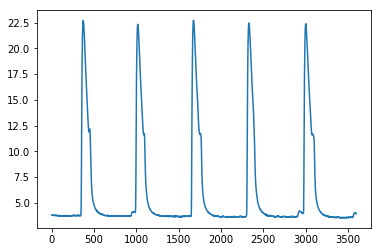

Muscle Bath 2


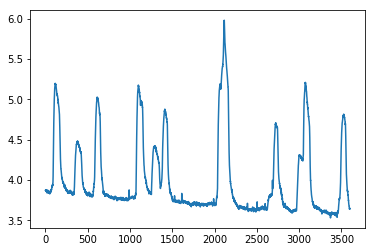

Muscle Bath 3


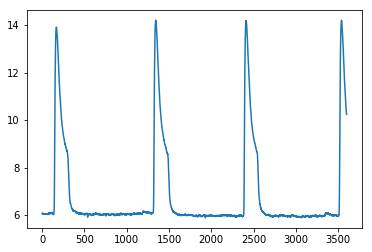

Muscle Bath 4


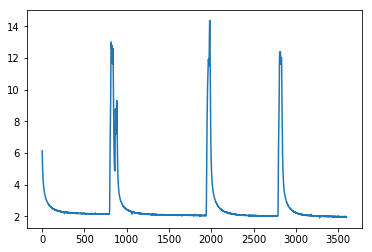

Muscle Bath 5


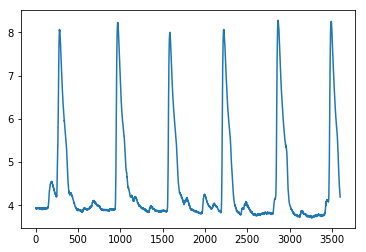

Muscle Bath 6


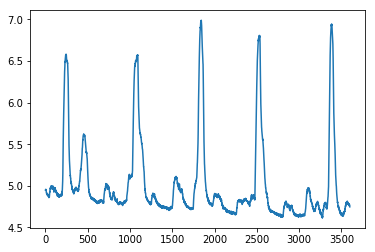

Muscle Bath 7


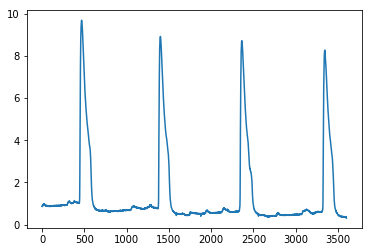

Muscle Bath 8


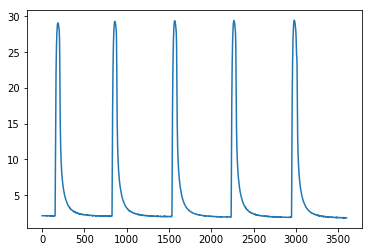

In [22]:
#plot the baseline contraction force data from
for bath in df_ref['Bath Number']:
    print("Muscle Bath",bath)
    plt.plot(np.array(baseline_array_list[bath-1]))
    plt.show()

In [69]:
#loop through baths in reference dataframe 
    #for each bath listed in the reference file, find the max/min(local extreme) for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr

#find local max values
#input the height cut off for peak analysis
locmax_list = []
fp_output_list = []
for bath in df_ref['Bath Number']:
    print("Muscle Bath",bath,":")
    cutoff = float(input("input peak height cutoff:"))
    fp_output = find_peaks(np.array(baseline_array_list[(bath-1)]),height = cutoff, width = 30)
    locmax = np.array(baseline_array_list[(bath-1)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)

Muscle Bath 1 :
input peak height cutoff:15
Muscle Bath 2 :
input peak height cutoff:4.5
Muscle Bath 3 :
input peak height cutoff:10
Muscle Bath 4 :
input peak height cutoff:10
Muscle Bath 5 :
input peak height cutoff:7
Muscle Bath 6 :
input peak height cutoff:6
Muscle Bath 7 :
input peak height cutoff:6
Muscle Bath 8 :
input peak height cutoff:20


In [77]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

[array([3.75170477, 3.7482556 , 3.74511536, 3.74227357, 3.73971972,
       3.73744332, 3.73543386, 3.73368085, 3.73217378, 3.73090217,
       3.72985552, 3.72902331, 3.72839507, 3.72796028, 3.72770845,
       3.72762908, 3.72771168, 3.72794573, 3.72832076, 3.72882625,
       3.72945171, 3.73018665, 3.73102055, 3.73194293, 3.73294329,
       3.73401112, 3.73513594, 3.73630723, 3.73751451, 3.73874727,
       3.73999502, 3.74124725, 3.74249347, 3.74372319, 3.74492589,
       3.7460911 , 3.74720829, 3.74826699, 3.74925668, 3.75016687,
       3.75098707, 3.75170677, 3.75231548, 3.75280269, 3.75315791,
       3.75337065, 3.75343039, 3.75332665, 3.75304892, 3.75258672,
       3.75192953, 3.75106686, 3.74998821, 3.74868309, 3.74714099,
       3.74535142, 3.74330388, 3.74098787, 3.73839289, 3.73550845]), array([3.72609183, 3.70465288, 3.68573987, 3.66926986, 3.65515993,
       3.64332713, 3.63368853, 3.6261612 , 3.62066219, 3.61710859,
       3.61541743, 3.61550581, 3.61729077, 3.62068938, 3.62

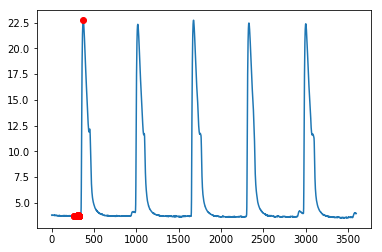

In [154]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
startlist = []
#create an empty list to store end indices
endlist = []
#create an empty list to store an arrays of baseline values
base_val_list = []
#loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
#store values in startlist and endlist
for peak_time in locmax_indx_list[0]:
    starttime = peak_time-105
    endtime = peak_time-45
    if starttime < 0:
        starttime = 0
    #if endtime < 0:
    #    break
    startlist.append(starttime)
    endlist.append(endtime)
#loop through contractions, calculate baseline values, assign values to spot in base_val_list
for i in range(len(startlist)):
    baseline_values = peakutils.baseline(np.array(baseline_array_list[0])[startlist[i]:endlist[i]])
    base_val_list.append(baseline_values)
    
print(base_val_list)
#print(baseline_array_list)
    
baseline_values = peakutils.baseline(np.array(baseline_array_list[0])[startlist[0]:endlist[0]])
plt.plot(np.array(baseline_array_list[0]))
plt.plot(np.arange(startlist[0],endlist[0]),baseline_values,'ro')
plt.plot(locmax_indx_list[0][0],locmax_list[0][0],'ro')


plt.show()



In [ ]:

#print(peak_list[0])
#print(peak_list[0].mean())
#print(peak_list[0].std())

#print(peak_idx_list[0][0])
    


In [80]:
#find the baseline force/minimum value before each peak

#x = argrelextrema(np.array(baseline_array_list[0]), np.less,order=100)
#print(np.array(baseline_array_list[0])[x])
#print(x)
#print(peak_idx_list[0][0])
#np.amin(np.array(baseline_array_list[0][0:500]))
#print(np.array(baseline_array_list[0])[0:500])



#baseline_values = peakutils.baseline(np.array(baseline_array_list[0])[500:1000])

#print(baseline_values)



In [81]:
#gradients=np.diff(np.array(baseline_array_list[0]))
#print(np.argmax(gradients))
#np.array(baseline_array_list[0])[2309]

#subtract minimum value from peak force to calculate amplitude of contraction
#calculate mean value of contraction amplitude
#calculate standard deviation
#calculate contractions amplitude corrected to CSA
#calculate mean value of contractions amplitude/CSA
#calculate standard deviation of contractions amplitude/CSA


#from max/min calculate the amplitudes/peaks
#calculate the average for each bath
#calculate the peaks 

#loop through baths and find peak forces
#input function to determine when baseline period should be

In [ ]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [95]:
#calculate duration/ relaxation time
peaks = find_peaks(np.array(baseline_array_list[0]),height = 10, width = 30)
print(peaks[1])

{'peak_heights': array([22.71, 22.33, 22.73, 22.45, 22.39]), 'prominences': array([19.013, 18.67 , 19.133, 18.857, 18.8  ]), 'left_bases': array([ 104,  757, 1511, 2061, 2773], dtype=int64), 'right_bases': array([1511, 1511, 3419, 3419, 3419], dtype=int64), 'widths': array([73.36527039, 75.12037037, 75.5745694 , 76.40619883, 78.65058712]), 'width_heights': array([13.2035, 12.995 , 13.1635, 13.0215, 12.99  ]), 'left_ips': array([ 353.30035461,  998.12962963, 1657.12304965, 2312.11222222,
       2984.2189781 ]), 'right_ips': array([ 426.665625  , 1073.25      , 1732.69761905, 2388.51842105,
       3062.86956522])}


In [ ]:
comments_file.close()